# Rice Type Classification Using Convolution Networks

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Reading Data

#### reading data into the juypter notebook 
#### labeling the each image by its folder name or class name
#### resizing the each image 

In [3]:
labels = []
images = []

for class_name in os.listdir('data/Rice_Image_Dataset'):
    class_path = os.path.join('data/Rice_Image_Dataset', class_name)
    files = os.listdir(class_path)[600:1200]
    for file in files:
        imag_path = os.path.join(class_path, file)
        
        img = cv2.imread(imag_path)
        img = cv2.resize(img, (224,224))
        
        images.append(img)
        labels.append(class_name)

## Preprocessing

### Normalizing

In [5]:
x = np.array(images)/255
y= np.array(labels)


In [7]:
x.shape

(3000, 224, 224, 3)

In [9]:
y

array(['Arborio', 'Arborio', 'Arborio', ..., 'Karacadag', 'Karacadag',
       'Karacadag'], dtype='<U9')

### label Encoder

In [11]:
le = LabelEncoder()

labelled_y = le.fit_transform(y)
labelled_y

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [13]:
onehot = to_categorical(labelled_y)
onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Visualizing images

Text(0.5, 1.0, 'Jasmine')

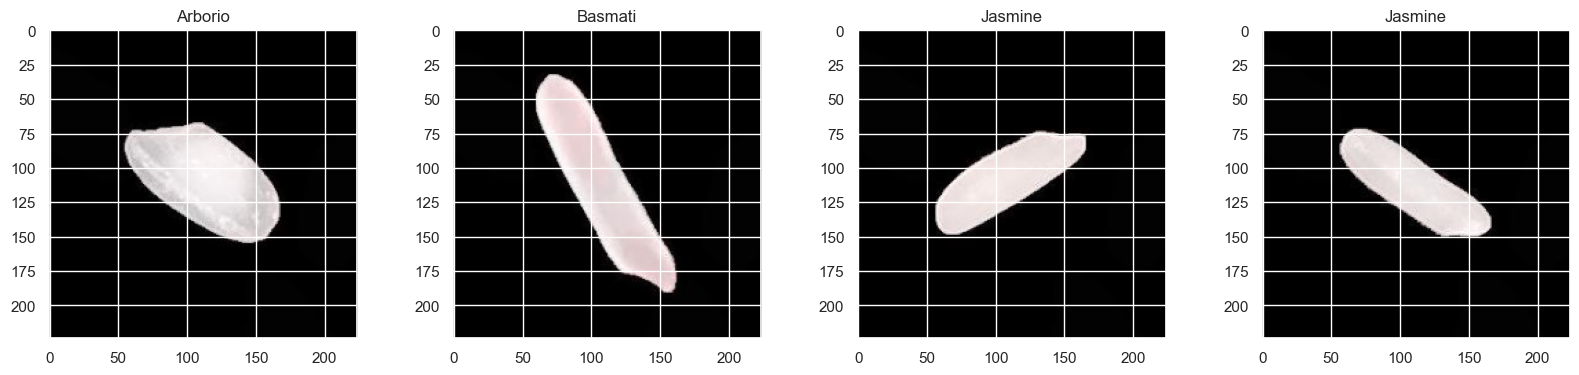

In [23]:

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].imshow(x[0])
ax[0].set_title(y[0])

ax[1].imshow(x[601])
ax[1].set_title(y[601])

ax[2].imshow(x[1902])
ax[2].set_title(y[1902])

ax[3].imshow(x[2126])
ax[3].set_title(y[2126])





### Shuffling Data

In [15]:
from sklearn.utils import shuffle

shuffled_x, shuffled_y = shuffle(x,onehot,random_state = 42)

## Splitting Data

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(shuffled_x, shuffled_y, test_size= 0.2, random_state = 42)

## Model Training

In [19]:
model = Sequential([
    Conv2D(32,(3,3), activation= 'relu', input_shape = (224,224,3)),
    MaxPooling2D(pool_size= (2,2)),
    Conv2D(64,(3,3), activation = 'relu'),
    MaxPooling2D(pool_size= (2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(5,activation='softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [23]:
epochs = 3
batch_size= 100
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= 'accuracy')

In [27]:
history = model.fit(
    x_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = callback,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/3
24/24 - 77s - loss: 0.8750 - accuracy: 0.7613 - val_loss: 0.1050 - val_accuracy: 0.9650 - 77s/epoch - 3s/step
Epoch 2/3
24/24 - 71s - loss: 0.0739 - accuracy: 0.9779 - val_loss: 0.0864 - val_accuracy: 0.9733 - 71s/epoch - 3s/step
Epoch 3/3
24/24 - 71s - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.1004 - val_accuracy: 0.9700 - 71s/epoch - 3s/step


## Visualizing Training, Validation Accuracy

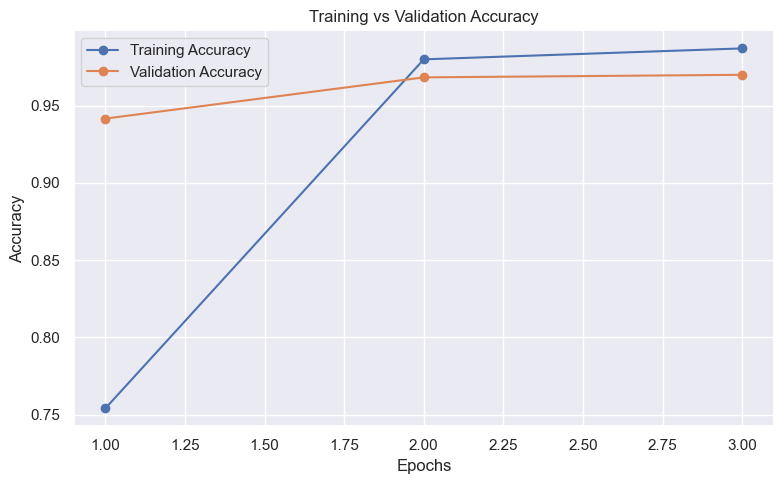

In [39]:
accu = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(accu) + 1)  # This line was missing in your code

plt.figure(figsize=(8, 5))
plt.plot(epochs, accu, label='Training Accuracy', marker='o')
plt.plot(epochs, val, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Saving the model

In [29]:
model.save("model.h5", include_optimizer=False)

## Predicting data

In [48]:
model.evaluate(x_test,y_test)

19/19 [==============================] - 5s 219ms/step - loss: 0.0909 - accuracy: 0.9700


[0.09094905853271484, 0.9700000286102295]

In [52]:
y_pred = model.predict(x_test)

19/19 [==============================] - 5s 219ms/step


In [88]:
y_predict_label = np.argmax(y_pred,axis=1)

In [90]:
y_pred_label = pd.Series(y_predict_label)

In [25]:
mapping = {
    0:'Arborio',
    1:'Basmati',
    2:'Ipsala',
    3:'Jasmine',
    4:'Karacadag'
}

In [94]:
y_predicted_classes = y_pred_label.map(mapping)

In [96]:
y_predicted_classes

0      Karacadag
1        Jasmine
2      Karacadag
3         Ipsala
4        Basmati
         ...    
595       Ipsala
596      Basmati
597       Ipsala
598      Basmati
599      Jasmine
Length: 600, dtype: object

## Predicting single image 

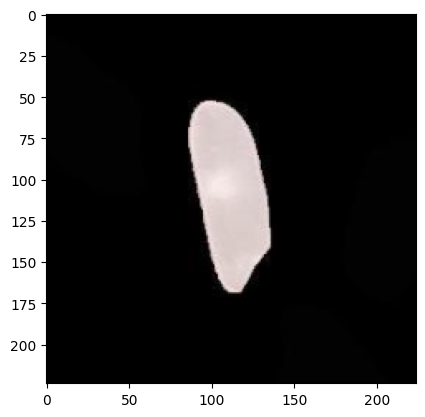

In [3]:

img_path = "data/Rice_Image_Dataset/Jasmine/Jasmine (1014).jpg"
sample_img = cv2.imread(img_path)
resized_image = cv2.resize(sample_img, (224,224))

transformed_img = resized_image/255

plt.imshow(transformed_img)

In [39]:
img = np.expand_dims(transformed_img, axis=0)

output = model.predict(img)
output

1/1 [==============================] - 0s 84ms/step


array([[1.0317592e-03, 1.5303182e-03, 1.6975818e-07, 9.9743712e-01,
        5.7116580e-07]], dtype=float32)

In [41]:
predict = np.argmax(output)
predict = pd.Series(predict)
predict.map(mapping)

0    Jasmine
dtype: object

In [3]:
!pip freeze > requirements.txt

In [5]:
!cat requirements.txt  # shows the contents

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
!pip freeze > requirements.txt


In [9]:
!type requirements.txt


absl-py @ file:///home/conda/feedstock_root/build_artifacts/absl-py_1733730548347/work
aiohappyeyeballs @ file:///home/conda/feedstock_root/build_artifacts/aiohappyeyeballs_1741285157081/work
aiohttp @ file:///D:/bld/aiohttp_1740481456133/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1734342155601/work
asttokens==3.0.0
astunparse @ file:///home/conda/feedstock_root/build_artifacts/astunparse_1736248061654/work
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1733235340728/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1737819173731/work
blinker @ file:///home/conda/feedstock_root/build_artifacts/blinker_1731096409132/work
Brotli @ file:///D:/bld/brotli-split_1725267609074/work
cached-property @ file:///home/conda/feedstock_root/build_artifacts/cached_property_1615209429212/work
cachetools @ file:///home/conda/feedstock_root/build_artifacts/cachetools_1740094013202/work
certifi @ file:///home/conda/feeds